In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 8.0 MB/s eta 0:00:00


In [4]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [5]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import random
from keras.optimizers import Adam

Segmentation Models: using `tf.keras` framework.


In [6]:
!unzip /content/drive/MyDrive/png.zip

Archive:  /content/drive/MyDrive/png.zip
   creating: png/
   creating: png/train/
  inflating: png/train/22828930_15.png  
  inflating: png/train/22828990_15.png  
  inflating: png/train/22829050_15.png  
  inflating: png/train/23429020_15.png  
  inflating: png/train/23429080_15.png  
  inflating: png/train/23578960_15.png  
  inflating: png/train/23579005_15.png  
  inflating: png/train/23729035_15.png  
  inflating: png/train/23879080_15.png  
  inflating: png/train/24179065_15.png  
  inflating: png/train/22678915_15.png  
  inflating: png/train/22678930_15.png  
  inflating: png/train/22678945_15.png  
  inflating: png/train/22678960_15.png  
  inflating: png/train/22678975_15.png  
  inflating: png/train/22678990_15.png  
  inflating: png/train/22679005_15.png  
  inflating: png/train/22679020_15.png  
  inflating: png/train/22679035_15.png  
  inflating: png/train/22679050_15.png  
  inflating: png/train/22828915_15.png  
  inflating: png/train/22828945_15.png  
  inflating: pn

In [7]:
def data_loader(folder_dir):
    image_dataset = []
    for images in os.listdir(folder_dir):
        image = cv2.imread(folder_dir+'/'+images, 1)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (256, 256))
        image = Image.fromarray(image)
        image = np.array(image)
        image_dataset.append(image)
    return image_dataset

In [8]:
image_dataset = data_loader("/content/png/train/") 

In [10]:
mask_dataset = data_loader("/content/png/train_labels/")

In [11]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [12]:
print(image_dataset.shape)
print(mask_dataset.shape)

(125, 256, 256, 3)
(125, 256, 256, 3)


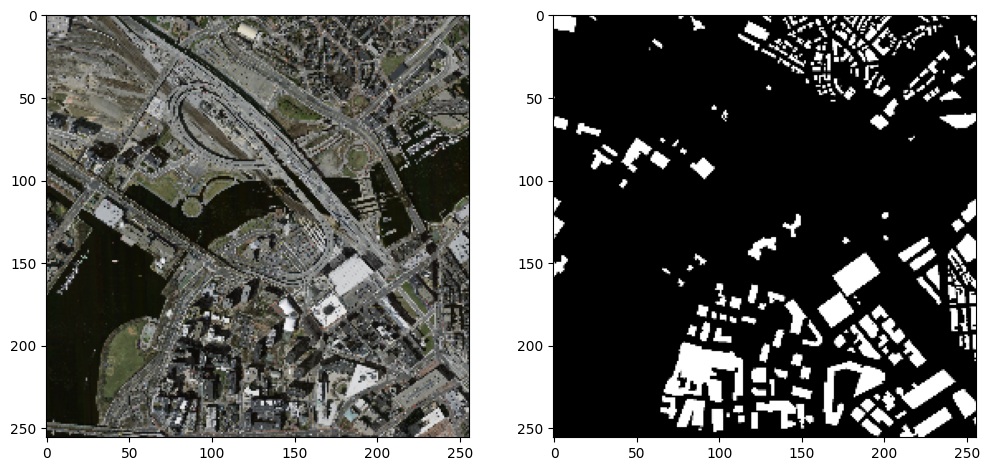

In [13]:
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(mask_dataset[image_number])
plt.show()

In [14]:
mask_labels = pd.read_csv('/content/label_class_dict.csv')

In [15]:
mask_labels

,name,r,g,b
0,background,0,0,0
1,building,255,255,255


In [16]:
def rgb_to_labels(img, mask_labels):
    label_seg = np.zeros(img.shape,dtype=np.uint8)
    for i in range(mask_labels.shape[0]):
        label_seg[np.all(img == list(mask_labels.iloc[i, [1,2,3]]), axis=-1)] = i
    label_seg = label_seg[:,:,0] 
    return label_seg

In [17]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_labels(mask_dataset[i], mask_labels)
    labels.append(label)

In [18]:
labels = np.array(labels)
labels = np.expand_dims(labels, axis=3) 

Unique labels in label dataset are:  [0 1]


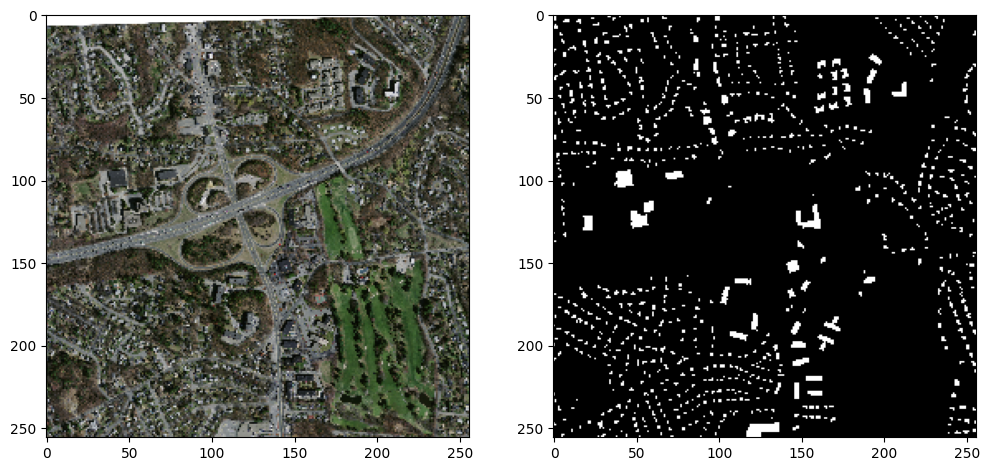

In [19]:
print("Unique labels in label dataset are: ", np.unique(labels))

image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0],cmap="gray")
plt.show()

In [20]:
n_classes = len(np.unique(labels))
print(n_classes)

2


In [21]:
labels_cat = to_categorical(labels, num_classes=n_classes)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

In [23]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(100, 256, 256, 3)
(25, 256, 256, 3)
(100, 256, 256, 2)
(25, 256, 256, 2)


In [24]:
BACKBONE = 'resnet34' 
preprocess_input = sm.get_preprocessing(BACKBONE)

In [25]:
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

In [26]:
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='sigmoid')

85521592/85521592 [==============================] - 0s 0us/step


In [27]:
metrics=['accuracy']
model_resnet_backbone.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

In [28]:
model_resnet_backbone.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)                                                          

In [29]:
history = model_resnet_backbone.fit(X_train_prepr, 
          y_train,
          batch_size=16, 
          epochs=100,
          verbose=1,
          validation_data=(X_test_prepr, y_test))

Epoch 1/100
7/7 [==============================] - 49s 1s/step - loss: 0.7372 - accuracy: 0.5320 - val_loss: 50.0307 - val_accuracy: 0.1189
Epoch 2/100
7/7 [==============================] - 2s 246ms/step - loss: 0.5245 - accuracy: 0.8614 - val_loss: 102.0032 - val_accuracy: 0.2661
Epoch 3/100
7/7 [==============================] - 2s 246ms/step - loss: 0.4460 - accuracy: 0.8779 - val_loss: 12.9682 - val_accuracy: 0.8008
Epoch 4/100
7/7 [==============================] - 2s 241ms/step - loss: 0.3985 - accuracy: 0.8789 - val_loss: 5.8944 - val_accuracy: 0.8758
Epoch 5/100
7/7 [==============================] - 2s 243ms/step - loss: 0.3661 - accuracy: 0.8792 - val_loss: 1.1536 - val_accuracy: 0.8885
Epoch 6/100
7/7 [==============================] - 2s 243ms/step - loss: 0.3461 - accuracy: 0.8794 - val_loss: 0.5953 - val_accuracy: 0.8885
Epoch 7/100
7/7 [==============================] - 2s 240ms/step - loss: 0.3279 - accuracy: 0.8794 - val_loss: 0.8749 - val_accuracy: 0.8885
Epoch 8/100

In [30]:
y_pred = model_resnet_backbone.predict(X_test) 
y_pred_binary = (y_pred > 0.5).astype(np.uint8)

1/1 [==============================] - 5s 5s/step


In [31]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth = y_test[test_img_number, :, :, 0]
predicted_img = y_pred_binary[test_img_number, :, :, 0] 

In [32]:
ground_truth = 1 - ground_truth
predicted_img = 1 - predicted_img

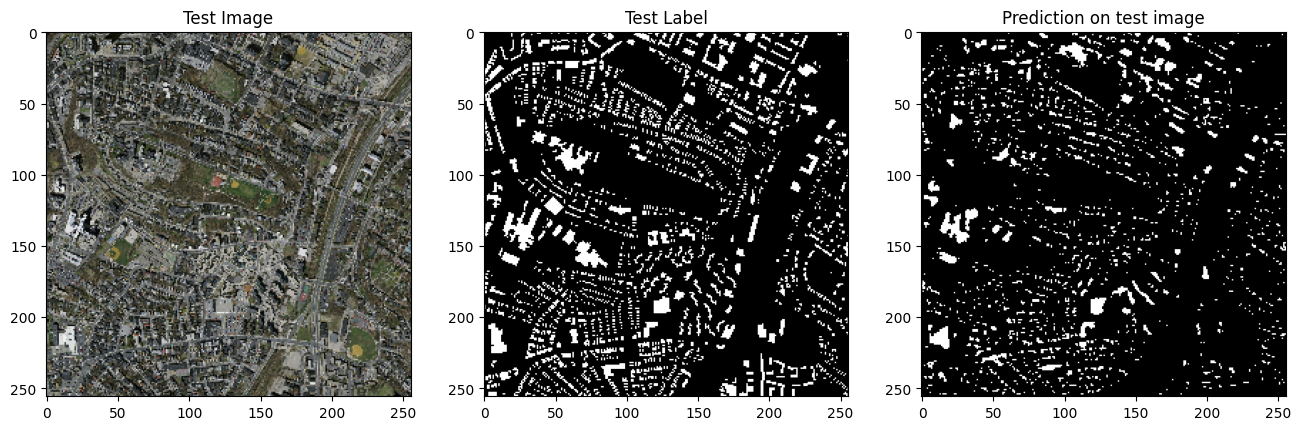

In [33]:
plt.figure(figsize=(16, 12))
plt.subplot(231)
plt.title('Test Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Test Label')
plt.imshow(ground_truth,cmap="gray")
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img,cmap="gray")
plt.show()

In [40]:
img = cv2.imread('/content/drive/MyDrive/tilotama.png')
test_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
image_prepr = preprocess_input(test_image)
image_prepr = cv2.resize(image_prepr, (256,256))  
image_prepr = np.expand_dims(image_prepr, axis=0)
predictions = model_resnet_backbone.predict(image_prepr)

1/1 [==============================] - 0s 32ms/step


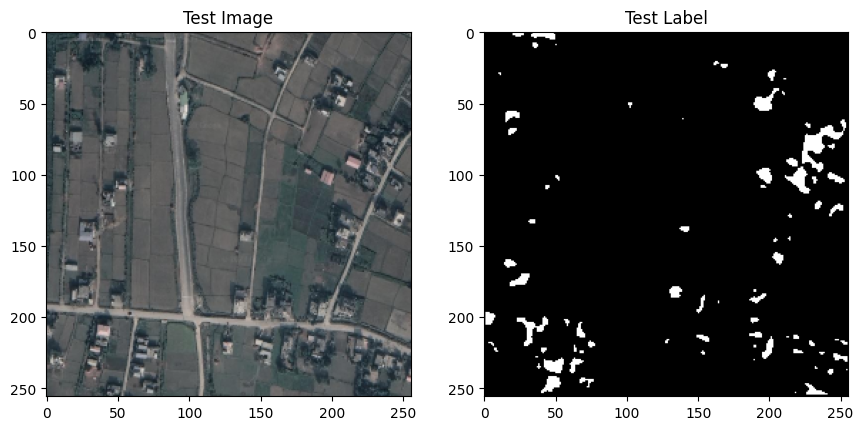

In [43]:
predicted_mask = np.argmax(predictions, axis=-1)
predicted_maskk = predicted_mask[0]
image = image_prepr[0]
image = image.reshape((256, 256, 3))
plt.figure(figsize=(16, 12))
plt.subplot(235)
plt.title('Test Image')
plt.imshow(image)
plt.subplot(236)
plt.title('Test Label')
plt.imshow(predicted_maskk,cmap="gray")
plt.show()

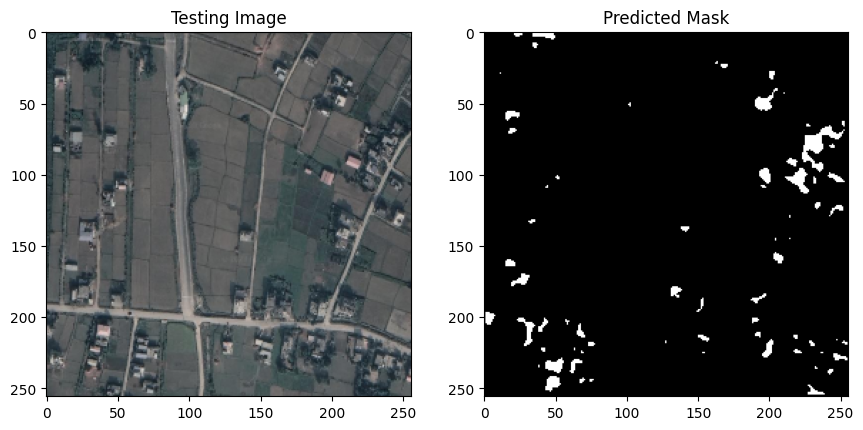

In [42]:
threshold = 0.4
predicted_mask = (predictions > threshold).astype(np.uint8)

predicted_mask = predicted_mask[0, :, :, 0]

image = image_prepr[0].reshape((256, 256, 3))

predicted_mask = 1 - predicted_mask

plt.figure(figsize=(16, 12))
plt.subplot(235)
plt.title('Testing Image')
plt.imshow(image)
plt.subplot(236)
plt.title('Predicted Mask')
plt.imshow(predicted_mask, cmap='gray')
plt.show()

In [ ]:
#model_resnet_backbone.save("resnet_segmentation.h5")